In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root="C:\\Users\\516-29\\chap13\\data", train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(
    root="C:\\Users\\516-29\\chap13\\data", train=False, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [15]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [16]:
encoder = Encoder(encoded_space_dim=4, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=4, fc2_input_dim=128)
encoder.to(device)
decoder.to(device)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=0.001, weight_decay=1e-05)
loss_fn = torch.nn.MSELoss()

In [17]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader:
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device)
        encoded_data = encoder(image_noisy)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_noisy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [18]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn, noise_factor=0.3):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [19]:
def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy, 0., 1.)
    return noisy

In [20]:
from matplotlib import font_manager
font_fname = 'C:/Windows/Fonts/malgun.ttf'
font_family = font_manager.FontProperties(fname=font_fname).get_name()
plt.rcParams["font.family"] = font_family

In [21]:
%matplotlib inline

def plot_ae_outputs(encoder, decoder, n=5, noise_factor=0.3):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(3, n, i+1)
        img = test_dataset[i][0].unsqueeze(0)
        image_noisy = add_noise(img, noise_factor)
        image_noisy = image_noisy.to(device)

        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(image_noisy))

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('원래 이미지')
            
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('노이즈가 적용되어 손상된 이미지')

        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('재구성된 이미지')
            
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.7,
                        top=0.9,
                        wspace=0.3,
                        hspace=0.3)
    plt.show()

EPOCH 1/30

 EPOCH 1/30 	 train loss 0.075 	 val loss 0.048


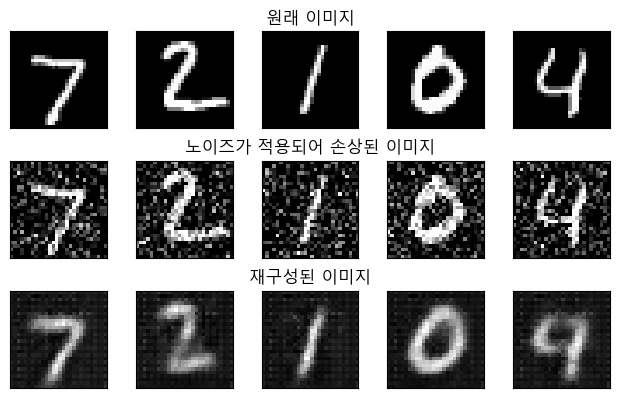

EPOCH 2/30

 EPOCH 2/30 	 train loss 0.054 	 val loss 0.043


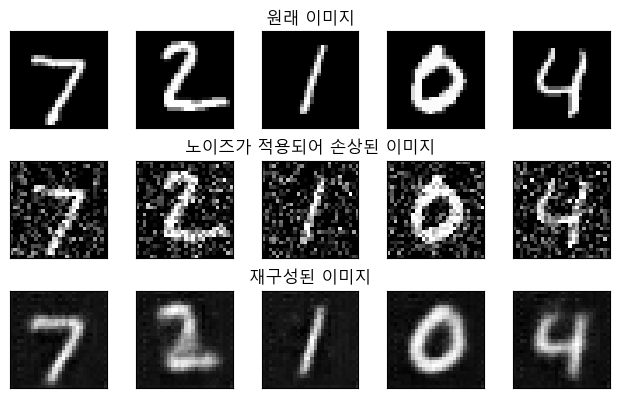

EPOCH 3/30

 EPOCH 3/30 	 train loss 0.053 	 val loss 0.042


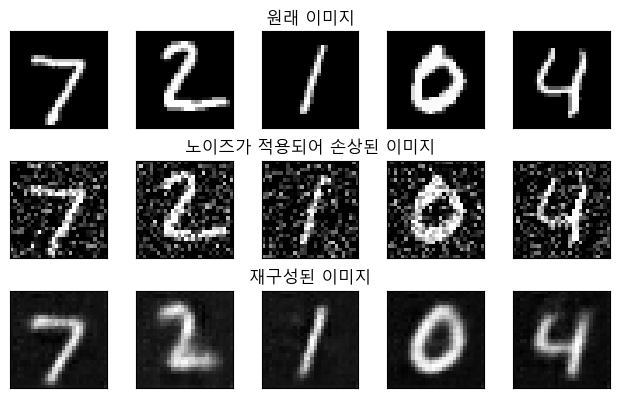

EPOCH 4/30

 EPOCH 4/30 	 train loss 0.052 	 val loss 0.041


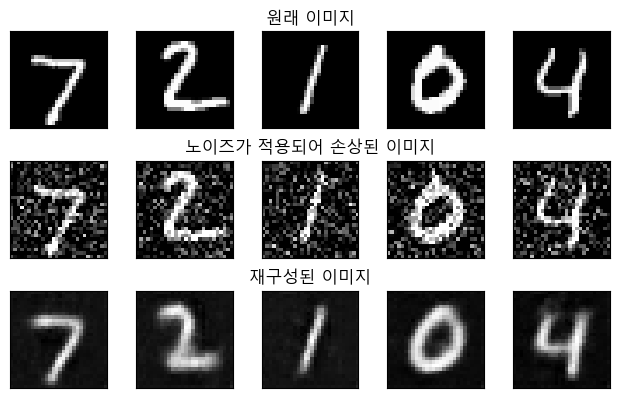

EPOCH 5/30

 EPOCH 5/30 	 train loss 0.051 	 val loss 0.041


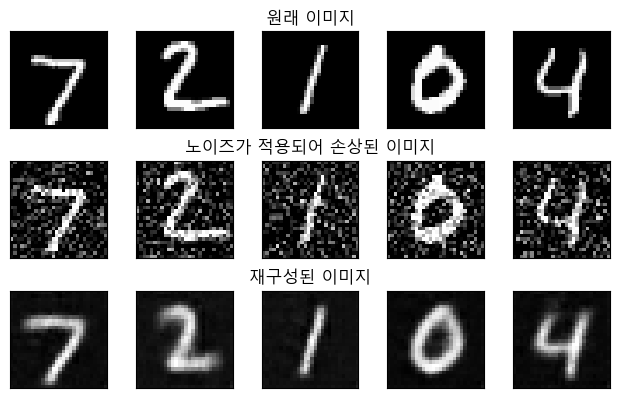

EPOCH 6/30

 EPOCH 6/30 	 train loss 0.051 	 val loss 0.041


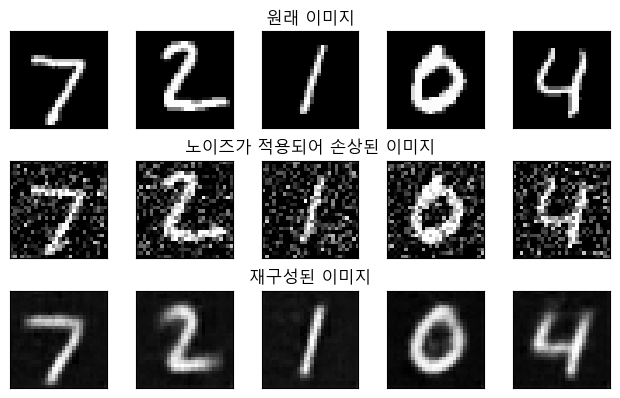

EPOCH 7/30

 EPOCH 7/30 	 train loss 0.051 	 val loss 0.040


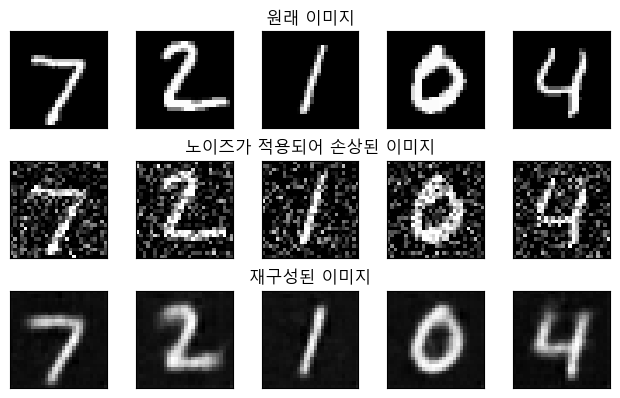

EPOCH 8/30

 EPOCH 8/30 	 train loss 0.051 	 val loss 0.040


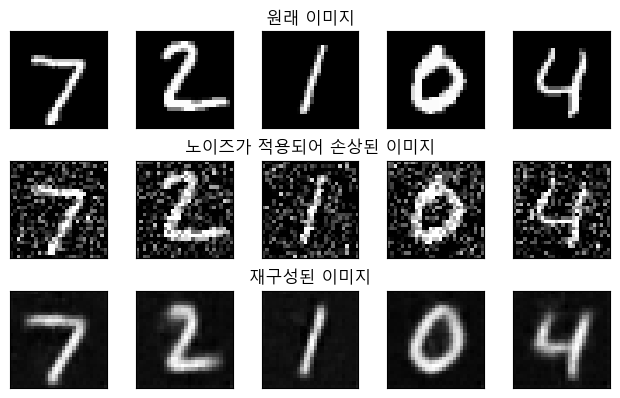

EPOCH 9/30

 EPOCH 9/30 	 train loss 0.051 	 val loss 0.040


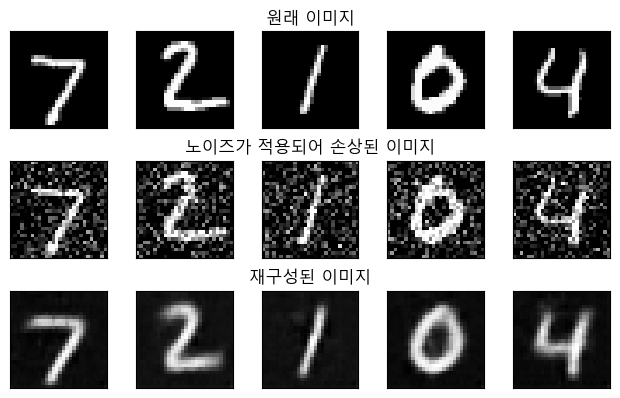

EPOCH 10/30

 EPOCH 10/30 	 train loss 0.050 	 val loss 0.039


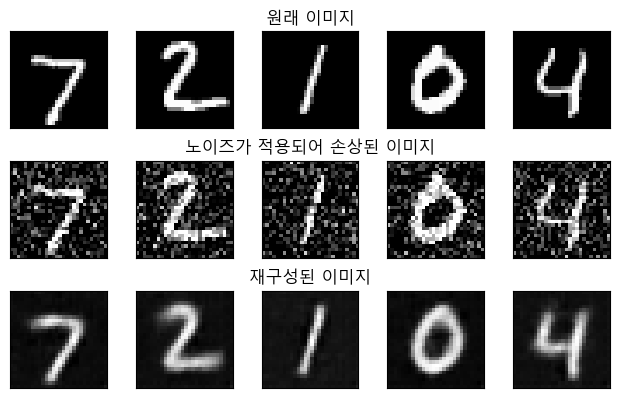

EPOCH 11/30

 EPOCH 11/30 	 train loss 0.050 	 val loss 0.039


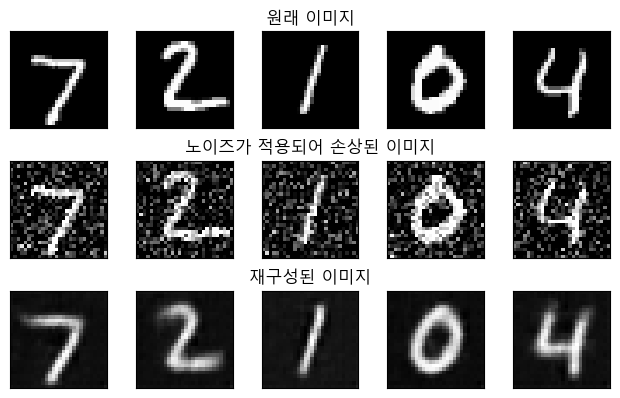

EPOCH 12/30

 EPOCH 12/30 	 train loss 0.050 	 val loss 0.039


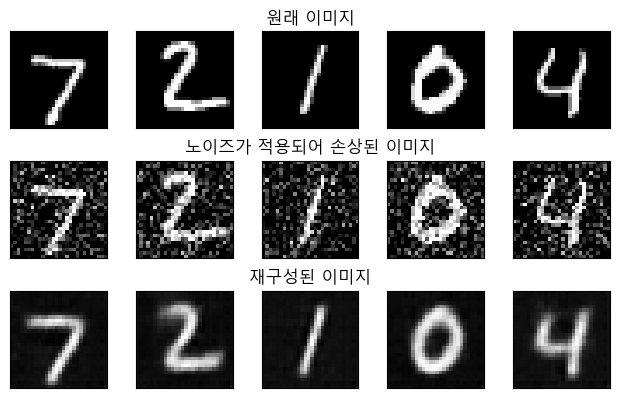

EPOCH 13/30

 EPOCH 13/30 	 train loss 0.050 	 val loss 0.039


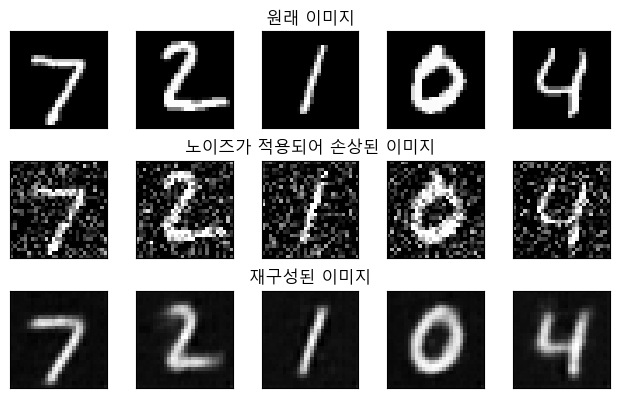

EPOCH 14/30

 EPOCH 14/30 	 train loss 0.050 	 val loss 0.039


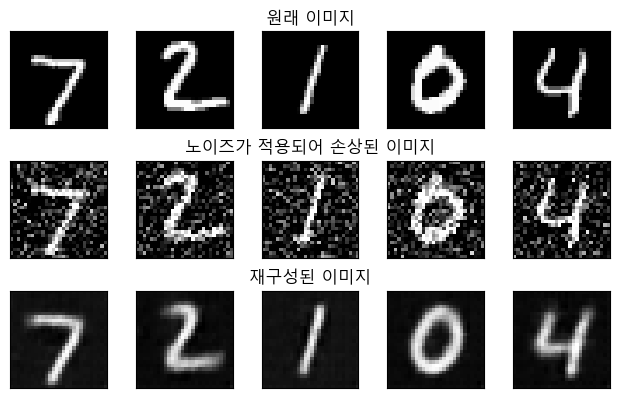

EPOCH 15/30

 EPOCH 15/30 	 train loss 0.050 	 val loss 0.039


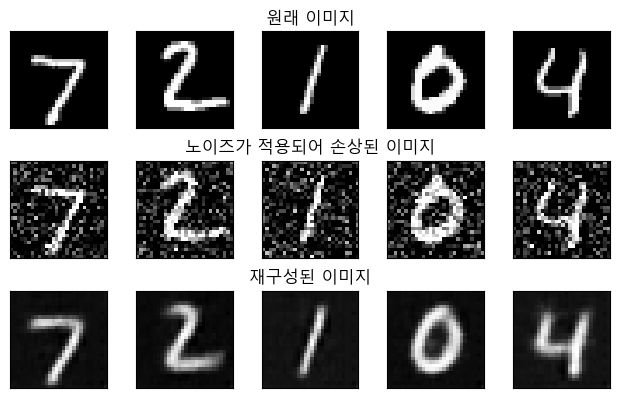

EPOCH 16/30

 EPOCH 16/30 	 train loss 0.050 	 val loss 0.039


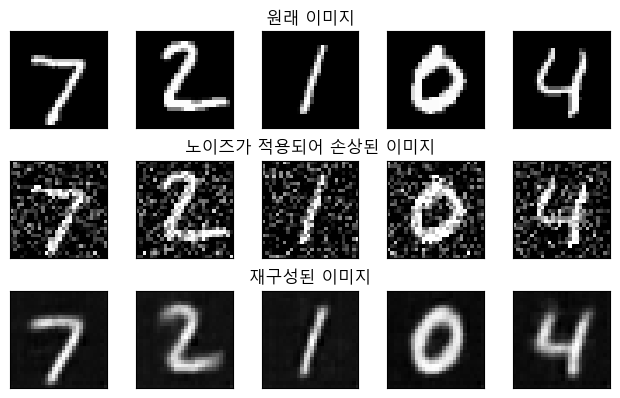

EPOCH 17/30

 EPOCH 17/30 	 train loss 0.050 	 val loss 0.039


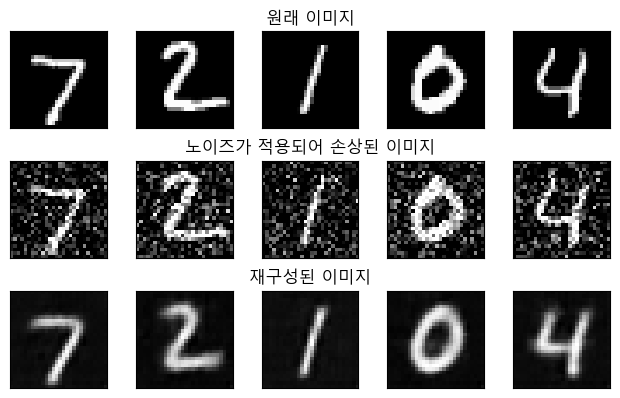

EPOCH 18/30

 EPOCH 18/30 	 train loss 0.050 	 val loss 0.038


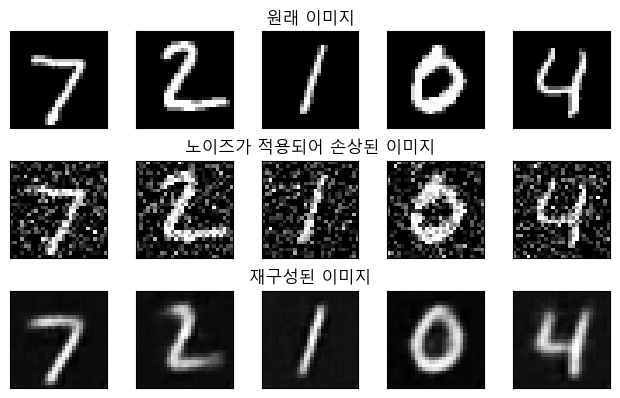

EPOCH 19/30

 EPOCH 19/30 	 train loss 0.050 	 val loss 0.038


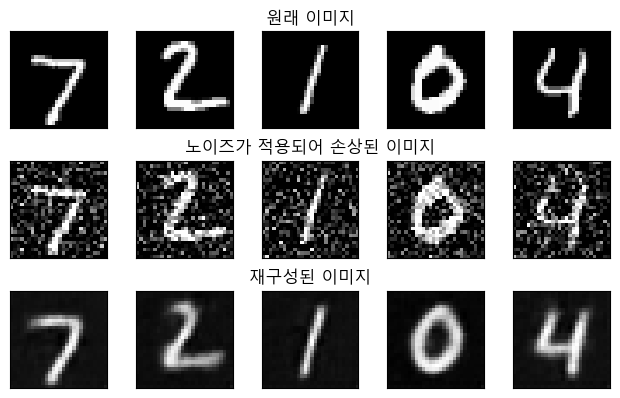

EPOCH 20/30

 EPOCH 20/30 	 train loss 0.050 	 val loss 0.038


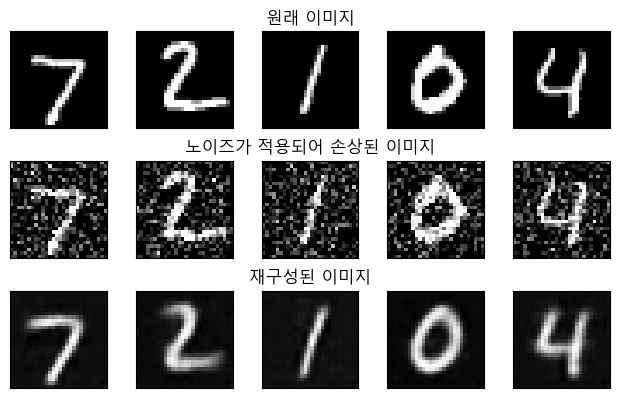

EPOCH 21/30

 EPOCH 21/30 	 train loss 0.050 	 val loss 0.039


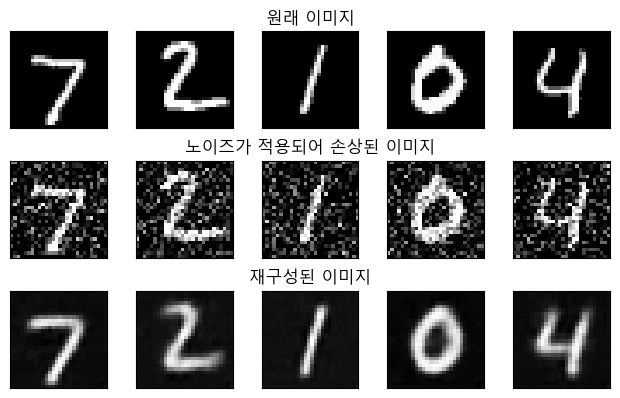

EPOCH 22/30

 EPOCH 22/30 	 train loss 0.050 	 val loss 0.038


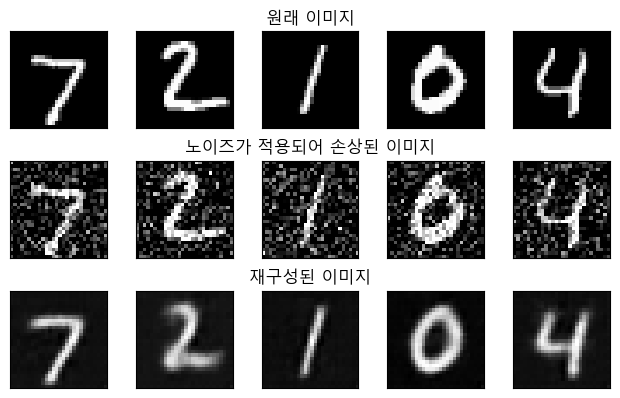

EPOCH 23/30

 EPOCH 23/30 	 train loss 0.049 	 val loss 0.038


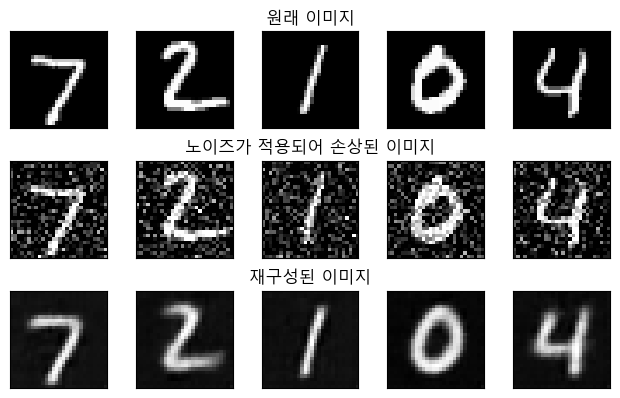

EPOCH 24/30

 EPOCH 24/30 	 train loss 0.049 	 val loss 0.038


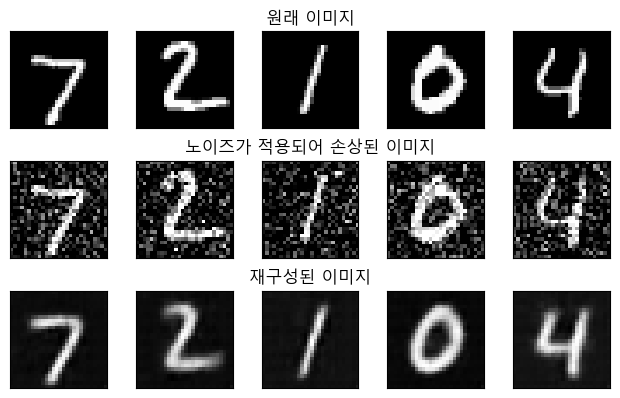

EPOCH 25/30

 EPOCH 25/30 	 train loss 0.049 	 val loss 0.038


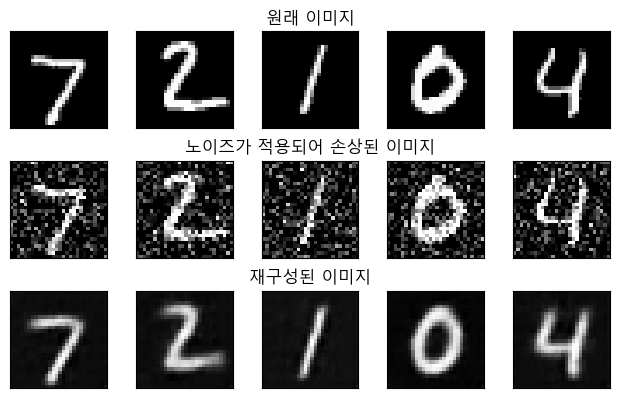

EPOCH 26/30

 EPOCH 26/30 	 train loss 0.049 	 val loss 0.038


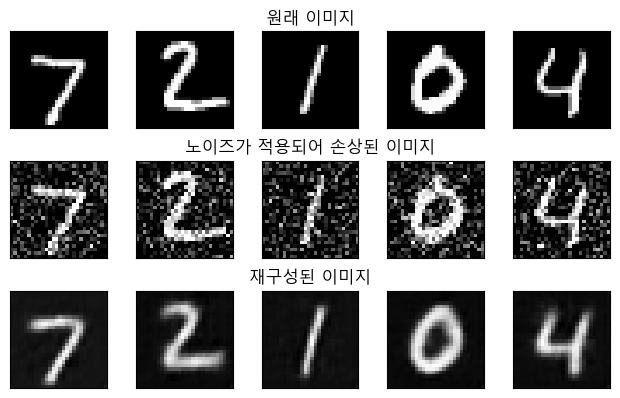

EPOCH 27/30

 EPOCH 27/30 	 train loss 0.049 	 val loss 0.038


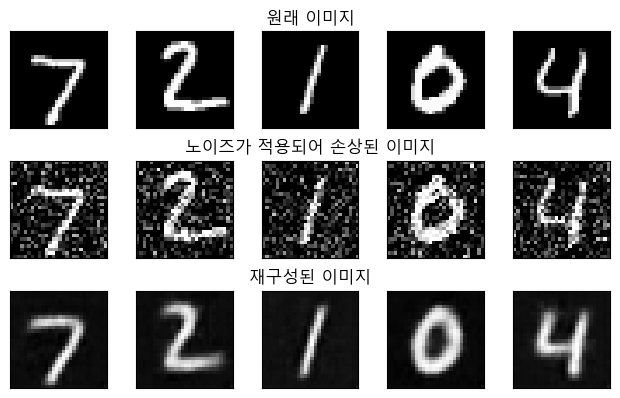

EPOCH 28/30

 EPOCH 28/30 	 train loss 0.049 	 val loss 0.038


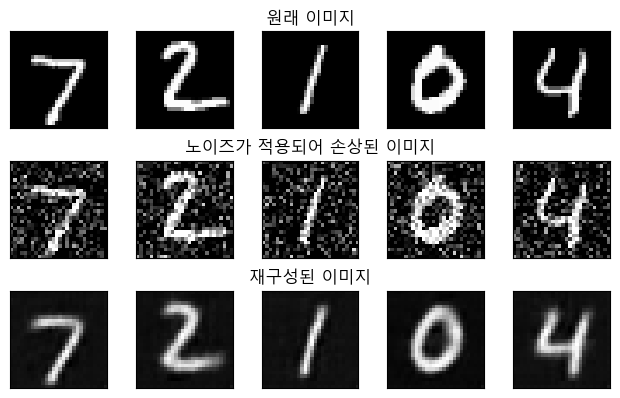

EPOCH 29/30

 EPOCH 29/30 	 train loss 0.049 	 val loss 0.038


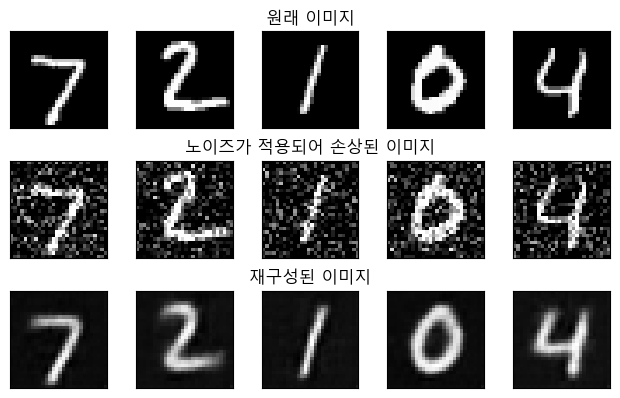

EPOCH 30/30

 EPOCH 30/30 	 train loss 0.049 	 val loss 0.038


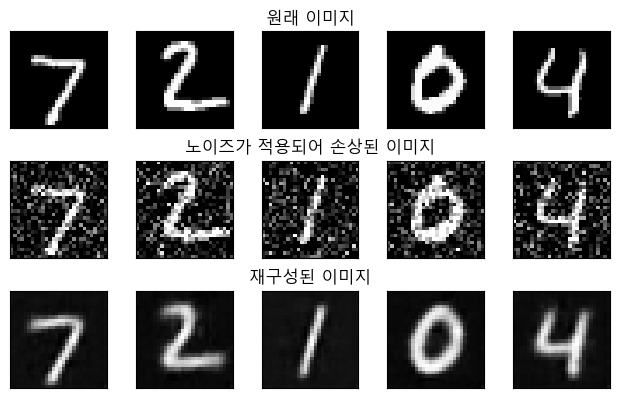

In [22]:
import numpy as np

num_epochs = 30
history_da = {'train_loss':[], 'val_loss':[]}
loss_fn = torch.nn.MSELoss()

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    train_loss=train_epoch(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=train_loader,
        loss_fn=loss_fn,
        optimizer=optim, noise_factor=0.3)
    
    val_loss = test_epoch(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=test_loader,
        loss_fn=loss_fn, noise_factor=0.3)
    
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs(encoder, decoder, noise_factor=0.3)

In [33]:
import datetime
import os
from tensorboardX import SummaryWriter

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root="C:\\Users\\516-29\\chap13\\data", train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(
    root="C:\\Users\\516-29\\chap13\\data", train=False, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=100, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(
    test_dataset, batch_size=100, shuffle=False, num_workers=4)

In [35]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input1 = nn.Linear(input_dim, hidden_dim)
        self.input2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True

    def forward(self, x):
        h_ = self.LeakyReLU(self.input1(x))
        h_ = self.LeakyReLU(self.input2(h_))
        mean = self.mean(h_)
        log_var = self.var(h_)
        return mean, log_var

In [36]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.hidden1(x))
        h = self.LeakyReLU(self.hidden2(h))
        x_hat = torch.sigmoid(self.output(h))
        return x_hat

In [37]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var * epsilon
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

In [49]:
x_dim = 784
hidden_dim = 400
latent_dim = 200
epochs = 2
batch_size = 100

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [50]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss, KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [51]:
saved_loc = 'scalar/'
writer = SummaryWriter(saved_loc)

model.train()

def train(epoch, model, train_loader, optimizer):
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        BCE, KLD = loss_function(x, x_hat, mean, log_var)
        loss = BCE + KLD
        writer.add_scalar("Train/Reconstruction Error", BCE.item(), batch_idx + epoch *
                         (len(train_loader.dataset)/batch_size))
        writer.add_scalar("Train/KL-Divergence", KLD.item(), batch_idx + epoch *
                         (len(train_loader.dataset)/batch_size))
        writer.add_scalar("Train/Total Loss", loss.item(), batch_idx + epoch *
                         (len(train_loader.dataset)/batch_size))

        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                  epoch, batch_idx * len(x), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader),
                  loss.item() / len(x)))

    print("======> Epoch: {} Average loss: {:.4f}".format(
          epoch, train_loss / len(train_loader.dataset)))

In [52]:
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)
            x_hat, mean, log_var = model(x)
            BCE, KLD = loss_function(x, x_hat, mean, log_var)
            loss = BCE + KLD

            writer.add_scalar("Test/Reconstruction Error", BCE.item(), batch_idx +
                              epoch * (len(test_loader.dataset)/batch_size))
            writer.add_scalar("Test/KL-Divergence", KLD.item(), batch_idx + epoch *
                              (len(test_loader.dataset)/batch_size))
            writer.add_scalar("Test/Total Loss", loss.item(), batch_idx + epoch *
                              (len(test_loader.dataset)/batch_size))
            test_loss += loss.item()

            if batch_idx == 0:
                n = min(x.size(0), 8)
                comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
                grid = torchvision.utils.make_grid(comparison.cpu())
                writer.add_image("Test image - Above: Real data, below: reconstruction data", grid, epoch)

In [53]:
from tqdm.auto import tqdm
for epoch in tqdm(range(0, epochs)):
    train(epoch, model, train_loader, optimizer)
    test(epoch, model, test_loader)
    print("\n")
writer.close()

  0%|          | 0/2 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	 Loss: 544.516836
Train Epoch: 0 [10000/60000 (17%)]	 Loss: 193.318379
Train Epoch: 0 [20000/60000 (33%)]	 Loss: 184.871758
Train Epoch: 0 [30000/60000 (50%)]	 Loss: 160.741855
Train Epoch: 0 [40000/60000 (67%)]	 Loss: 154.452861
Train Epoch: 0 [50000/60000 (83%)]	 Loss: 146.829746
======> Epoch: 0 Average loss: 173.7350


Train Epoch: 1 [0/60000 (0%)]	 Loss: 140.439980
Train Epoch: 1 [10000/60000 (17%)]	 Loss: 137.436709
Train Epoch: 1 [20000/60000 (33%)]	 Loss: 135.476064
Train Epoch: 1 [30000/60000 (50%)]	 Loss: 129.298770
Train Epoch: 1 [40000/60000 (67%)]	 Loss: 121.387021
Train Epoch: 1 [50000/60000 (83%)]	 Loss: 121.699189
======> Epoch: 1 Average loss: 128.8339




In [55]:
%load_ext tensorboard
%tensorboard --logdir scalar --port=6013